<a href="https://colab.research.google.com/github/ericshermancs/detectron2/blob/master/Detectron2_custom_coco_data_segmentation_12112020_0815_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla T4'

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
#!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__
torch.cuda.is_available()

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-f4r24otn
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-f4r24otn
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=44221 sha256=6590c6b0aaf9e27152d01df4328510014ed43e0be907282b6db60cd41ca248de
  Stored in directory: /tmp/pip-ephem-wheel-cache-j3kpl18r/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore


True

In [2]:
!git clone https://github.com/ericshermancs/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.3
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import importlib
import detectron2
importlib.reload(detectron2)
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [2]:
# download, decompress the data
#!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
#!unzip data.zip > /dev/null

!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
!unzip downloads/cocostuff-10k-v1.1.zip -d cocostuff-10k-v1.1/ 
!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.json
!ls .
!ls ./cocostuff-10k-v1.1/ 


Streaming output truncated to the last 5000 lines.
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000141101.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000110894.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000331298.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000071344.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000531647.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000376806.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000269090.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000213623.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000418479.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000282946.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000236057.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000222036.jpg  
  inflating: cocostuff-10k-v1.1/images/COCO_train2014_000000084609.jpg  


In [ ]:
import json
ann_file = json.load(open('downloads/cocostuff-10k-v1.1.json'))
id_list = [x["id"] for x in ann_file['annotations']]

from collections import Counter
import pycocotools
counter = Counter(id_list)
duplicates_set = {i[0] for i in counter.most_common() if i[1]>1}
max_id = max(id_list)

dupe_counter = 1
rle_ann_list = []
for annotation in ann_file['annotations']:
    _id = annotation['id']
    if 'iscrowd' in annotation:
        if annotation['iscrowd'] == 1:
            rle_ann_list.append(annotation)
        annotation['iscrowd'] = 0
        
        
    if _id in duplicates_set:
        annotation['id'] = max_id + dupe_counter
        dupe_counter += 1

    if isinstance(annotation['segmentation'], list):
        if isinstance(annotation['segmentation'][0], dict):

            decoding = pycocotools.mask.decode(annotation['segmentation'][0])

            _contours, hierarchy = cv2.findContours(decoding, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
            contours = map(np.squeeze, _contours)  # removing redundant dimensions
            coords = []
            for cont in contours:
                coords.append(cont.flatten().tolist())

            annotation['segmentation'] = coords
    
    if isinstance(annotation['bbox'][0], list):
      annotation['bbox'] = annotation['bbox'][0]
    
    
with open('downloads/cocostuff_unique.json', 'w+') as outfile:
    json.dump(ann_file, outfile)



In [50]:
from pprint import pprint
pprint(rle_ann_list[0])
import pycocotools


print(coords)

{'area': 175924.0,
 'bbox': [[0.0, 104.0, 640.0, 322.0]],
 'category_id': 155,
 'id': 2,
 'image_id': 405628,
 'iscrowd': 0,
 'segmentation': [{'counts': 'Q5Y8Q50O100O100O1LgGWKY8j432N001O1O00000000002NM300O1O11O001OO1KdGYK_8g42O100O100N2003M2N00N21O0000002N00O1O1N21OM_G]Ka8d421OO11O00000000O11O00O1O100O10000001O0000O1001O1O1O00O100000000M\\G_Ke8`4300N21O1O002N001O001O00OaH]KY6c4bH]Km06a6_4[IdKf6\\4ZIfKd6Y4\\IiKc6W4[IgKi6Y4WIgKi6Z4QI[K_O>`7V4RIlKn6R4`H^Kb0`0n6R4TImKm6S4SImKm6S4SIlKn6T4SIkKm6V4RIiKo6V4RIjKn6V4SIiKm6X4RIgKo6Y4PIhKP7X4PIgKQ7Y4oHgKQ7Y4nHhKR7Y4mHfKT7X4mHiKS7U4ZH`Kb0;U7U4YH`Kb0;U7R4ZHcKb0<T7Q4nHoKS7l3oHhKYO=h7k3oHVLR7k3mHULS7j3nHVLR7k3mHTLT7l3lHTLT7l3kHTLV7n3hHRLX7n3gHSLY7k3hHULZ1Dn3W4hJULY1Lh3o3nJULZ1Of3l3PKULY10g3k3PKULX11h3j3PKTLX13h3i3PKTLW14i3h3PKSLW16i3f3QKTLU17j3e3QKTLT18k3d3PKTLU19k3c3PKTLT1:l3b3PKTLS1;m3a3PKSLS1=m3`3PKSLR1>n3^3QKTLP1?o3]3RKSLn0a0P4]3QKSLm0a0R4\\3QKSLl0b0S4\\3PKRLl0c0T4[3PKSLj0c0V4Z3PKSLi0d0W4Y3PKSLh0e0X4V3RKULe0f0Y4S3TKWLb0g0Z4o2WK[L=g0\\4j2^JSLj0<;

In [ ]:
from pycocotools import coco
c = coco.COCO('downloads/cocostuff_unique.json')



{'area': 92634.0, 'bbox': [45.0, 100.0, 595.0, 327.0], 'category_id': 111, 'id': 5585, 'image_id': 85018, 'iscrowd': 0, 'segmentation': [[257, 171, 257, 172, 259, 174, 258, 175, 258, 176, 257, 177, 258, 178, 257, 179, 258, 180, 258, 181, 257, 182, 257, 183, 258, 184, 258, 185, 259, 185, 260, 186, 260, 185, 261, 184, 263, 186, 263, 185, 264, 184, 265, 185, 268, 185, 269, 184, 270, 185, 271, 185, 271, 184, 272, 183, 272, 178, 273, 177, 272, 176, 272, 175, 273, 174, 273, 172, 271, 172, 270, 171, 267, 171, 266, 172, 265, 171, 262, 171, 261, 172, 260, 171], [87, 100, 88, 101, 82, 107, 80, 107, 79, 106, 77, 106, 76, 105, 72, 105, 71, 104, 71, 101, 70, 101, 70, 102, 69, 103, 69, 104, 68, 105, 68, 106, 66, 108, 66, 109, 65, 110, 65, 111, 64, 112, 64, 113, 63, 114, 63, 115, 62, 116, 60, 114, 54, 114, 53, 113, 52, 113, 52, 114, 50, 116, 49, 116, 49, 117, 47, 119, 45, 119, 45, 122, 47, 124, 47, 129, 49, 131, 49, 132, 50, 133, 50, 134, 51, 133, 58, 133, 59, 132, 65, 132, 67, 134, 67, 135, 69, 135,

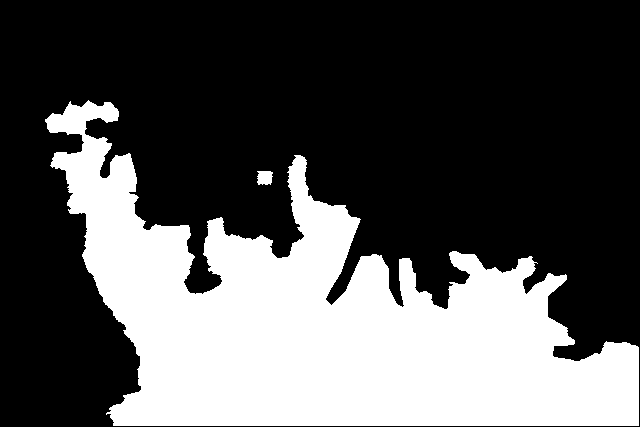

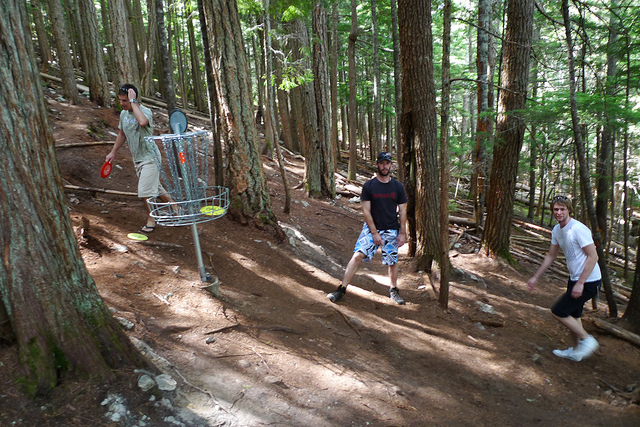

In [25]:

C_ID = 5585
ann = c.loadAnns(C_ID)[0].copy()
print(ann, flush=True)
print(c.loadCats(ann['category_id']))
image_id = ann['image_id']
print(type(ann['image_id']))

IMAGE_PATH = './cocostuff-10k-v1.1/images/'
img_dict = c.loadImgs(image_id)[0]
print(img_dict)
full_path = IMAGE_PATH + 'COCO_train2014_' +str(image_id).zfill(12)+'.jpg'
print(full_path)
img = cv2.imread(full_path)

if type(ann['segmentation'][0]) == dict:
  ann['segmentation'] = ann['segmentation'][0]
mask = c.annToMask(ann)
import cv2
from google.colab.patches import cv2_imshow
#cv2_imshow(img)
cv2_imshow(mask*255)
cv2_imshow(img)

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
#from detectron2.data.datasets import register_coco_instances
#register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")
import time
from detectron2.data.datasets import register_coco_instances
CURRENT_CATALOG_NAME = str(time.time())
register_coco_instances( CURRENT_CATALOG_NAME, {}, 'downloads/cocostuff_unique.json' ,'./cocostuff-10k-v1.1/images' )

In [ ]:
#fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
#dataset_dicts = DatasetCatalog.get("fruits_nuts")

fruits_nuts_metadata = MetadataCatalog.get( CURRENT_CATALOG_NAME )
#coco10k_metadata = MetadataCatalog.get( 'COCO10k' )
dataset_dict = DatasetCatalog.get( CURRENT_CATALOG_NAME )

In [13]:
for im in dataset_dict:
    if im['image_id'] == 57870:
      print(im)

{'file_name': './cocostuff-10k-v1.1/images/COCO_train2014_000000057870.jpg', 'height': 480, 'width': 640, 'image_id': 57870, 'annotations': [{'iscrowd': 0, 'bbox': [233.29, 270.45, 170.32, 203.36], 'category_id': 56, 'segmentation': [[233.29, 461.42, 235.35, 395.35, 240.52, 378.84, 245.68, 372.65, 250.84, 372.65, 283.87, 372.65, 294.19, 362.32, 298.32, 345.81, 301.42, 329.29, 303.48, 308.65, 311.74, 290.06, 330.32, 278.71, 348.9, 272.52, 363.35, 270.45, 388.13, 274.58, 401.55, 291.1, 403.61, 318.97, 395.35, 341.68, 388.13, 361.29, 378.84, 380.9, 373.68, 393.29, 366.45, 407.74, 365.42, 429.42, 366.45, 451.1, 376.77, 468.65, 377.81, 469.68, 361.29, 469.68, 353.03, 469.68, 317.94, 461.42, 313.81, 471.74, 299.35, 472.77, 297.29, 463.48, 244.65, 457.29, 243.61, 472.77, 238.45, 473.81, 237.42, 473.81]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [1.02, 279.96, 533.09, 200.04], 'category_id': 60, 'segmentation': [[4.41, 338.69, 27.0, 342.08, 38.29, 361.28, 41.68, 378.22, 39.4

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [15]:
import random

for d in random.sample(dataset_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

IndexError: ignored

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
#cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = (CURRENT_CATALOG_NAME,)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 8
#cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_C4_1x/137257644/model_final_721ade.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 11
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 1200    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 183  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print( 'before trainer' )
trainer = DefaultTrainer(cfg)
print('after trainer')
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [9]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (CURRENT_CATALOG_NAME, )
predictor = DefaultPredictor(cfg)

./output/model_final.pth


Then, we randomly select several samples to visualize the prediction results.

--2020-12-11 13:07:25--  http://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg
Resolving farm5.staticflickr.com (farm5.staticflickr.com)... 13.32.201.87, 2600:9000:2015:4600:0:5a51:64c9:c681, 2600:9000:2015:f400:0:5a51:64c9:c681, ...
Connecting to farm5.staticflickr.com (farm5.staticflickr.com)|13.32.201.87|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg [following]
--2020-12-11 13:07:25--  https://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg
Connecting to farm5.staticflickr.com (farm5.staticflickr.com)|13.32.201.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test.png’

test.png                [ <=>                ] 130.21K  --.-KB/s    in 0.003s  

2020-12-11 13:07:25 (41.1 MB/s) - ‘test.png’ saved [133338]



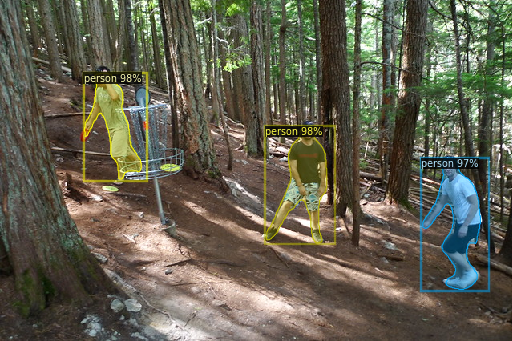

In [26]:
from detectron2.utils.visualizer import ColorMode

!wget http://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg -O test.png
im = cv2.imread("test.png")
# print(im)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=fruits_nuts_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [25]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./cocostuff-10k-v1.1/images', json_file='downloads/cocostuff_unique.json', name='fruits_nuts', thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.12,fps:8.04


In [ ]:
!ls -l ./output/

total 700996
-rw-r--r-- 1 root root      1110 Dec 11 05:00 events.out.tfevents.1607662837.2252d2ce8568.358.0
-rw-r--r-- 1 root root      2180 Dec 11 05:10 events.out.tfevents.1607663414.2252d2ce8568.358.1
-rw-r--r-- 1 root root      3250 Dec 11 05:13 events.out.tfevents.1607663541.2252d2ce8568.541.0
-rw-r--r-- 1 root root     27170 Dec 11 05:26 events.out.tfevents.1607663665.2252d2ce8568.674.0
-rw-r--r-- 1 root root        15 Dec 11 05:26 last_checkpoint
-rw-r--r-- 1 root root     23169 Dec 11 05:26 metrics.json
-rw-r--r-- 1 root root 358870196 Dec 11 05:26 model_final.pth
-rw-r--r-- 1 root root 358870196 Dec 11 05:48 model_IPB5_MI500_BSI256.pth


In [27]:
from google.colab import files
!cp ./output/model_final.pth ./output/model_IPB5_MI200_BSI128_STUFF.pth
files.download('./output/model_IPB5_MI200_BSI128_STUFF.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>